In [1]:
from torch.utils.data import DataLoader, Subset
from gym_av_aloha.datasets.av_aloha_dataset import AVAlohaDataset
from gaze_av_aloha.policies.gaze_policy.gaze_model import GazeModel
import torch
from torch import nn, Tensor
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio
import cv2
from IPython.display import Video, display
import einops
import kornia.augmentation as K
import torch.nn.utils as nn_utils
import os
from hydra import initialize_config_dir, compose
from gaze_av_aloha.configs import Config
from torchvision.transforms import Resize, Normalize
import torch.nn.functional as F


In [13]:
input_shape = (240, 320)
resize_shape=(120, 160)
task = "slot_insertion"
dataset = f"iantc104/av_aloha_sim_{task}"
model_repo_id = f"iantc104/gaze_model_av_aloha_sim_{task}"
image_keys = [
    "observation.images.zed_cam_left",
]
eye_keys = [
    "left_eye",
]

In [14]:

delta_timestamps = {
    k: [0] for k in image_keys + eye_keys
}
dataset = AVAlohaDataset(
    repo_id=dataset,
    delta_timestamps=delta_timestamps,
)
dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GazeModel(
    resize_shape=resize_shape,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

transforms = K.AugmentationSequential(
    K.RandomCrop(size=(int(input_shape[0]*0.9), int(input_shape[1]*0.9)), p=0.5),
    K.ColorJiggle(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    K.RandomPerspective(distortion_scale=0.5, p=0.1),
    K.RandomHorizontalFlip(p=0.1),
    K.RandomRotation(degrees=15, p=0.1),
    K.RandomErasing(scale=(0.02, 0.2), ratio=(0.3, 3.3), p=0.1),
    data_keys=["input", "keypoints"],
    same_on_batch=True,
)
resize = Resize(input_shape)
normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [16]:
def denormalize_keypoints(
    keypoints: Tensor, image_size: tuple[int, int]
) -> Tensor:
    """
    Arguments:
        keypoints: Tensor of shape (..., 2)
            where the last dimension contains (x, y) coordinates of keypoints.
        image_size: Tuple (height, width) of the image.
    Denormalize keypoints from [-1, 1] range to pixel coordinates based on image size.
    """
    height, width = image_size
    return torch.stack(
        [
            ((keypoints[..., 0] + 1) / 2) * width,  # Denormalize x to pixel coordinates
            ((keypoints[..., 1] + 1) / 2) * height,  # Denormalize y to pixel coordinates
        ],
        dim=-1,
    )

def normalize_keypoints(
    keypoints: Tensor, image_size: tuple[int, int]
) -> Tensor:
    """
    Arguments:
        keypoints: Tensor of shape (..., 2)
            where the last dimension contains (x, y) coordinates of keypoints.
        image_size: Tuple (height, width) of the image.
    Normalize keypoints to [-1, 1] range based on image size.
    """
    height, width = image_size
    return torch.stack(
        [
            (keypoints[..., 0] / width) * 2 - 1,  # Normalize x to [-1, 1]
            (keypoints[..., 1] / height) * 2 - 1,  # Normalize y to [-1, 1]
        ],
        dim=-1,
    )

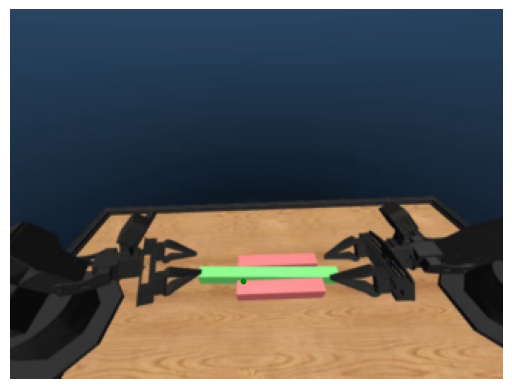

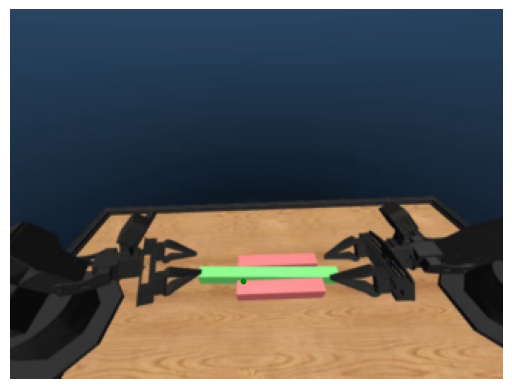

In [17]:
batch = next(iter(dataloader))
image = batch[image_keys[0]].squeeze(1)
eye = batch[eye_keys[0]]

plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
plt.scatter(
    (eye[0, 0, 0].cpu().numpy() + 1) / 2 * image.shape[-1],
    (eye[0, 0, 1].cpu().numpy() + 1) / 2 * image.shape[-2],
    c="green",
    s=10,
)
plt.axis("off")
plt.show()

image = resize(image)
eye = denormalize_keypoints(eye, image.shape[-2:])
image, eye = transforms(image, eye)
plt.imshow(image[0].permute(1, 2, 0).cpu().numpy())
plt.scatter(
    eye[0, 0, 0].cpu().numpy(),
    eye[0, 0, 1].cpu().numpy(),
    c="green",
    s=10,
)
plt.axis("off")
plt.show()

In [18]:
num_epochs = 10
losses = []
# entropy_weight = 0.001  # Weight for the entropy loss term
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch in pbar:
        data = {k: v.to(device).squeeze(1) for k, v in batch.items() if k in image_keys + eye_keys}
        data["task"] = batch["task"]
        image = einops.rearrange(
            torch.stack([data[k] for k in image_keys], dim=1),
            'b n c h w -> (b n) c h w', n=len(image_keys)
        )
        eye = einops.rearrange(
            torch.stack([data[k] for k in eye_keys], dim=1),
            'b n e -> (b n) 1 e', n=len(image_keys)
        )
        image = resize(image)
        eye = denormalize_keypoints(eye, image.shape[-2:])
        image, eye = transforms(image, eye)
        eye = normalize_keypoints(eye, image.shape[-2:]).squeeze(1)
        image = normalize(image)
        
        optimizer.zero_grad()
        pred, _ = model(image)
        loss = F.mse_loss(pred, eye).mean()
        loss.backward()
      
        optimizer.step()
        total_loss += loss.item() * eye.size(0)

        losses.append(loss.item())

        # Update tqdm progress bar
        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader.dataset)
    print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}")

Epoch 1/10: 100%|██████████| 278/278 [00:25<00:00, 10.95it/s, loss=0.0061] 


Epoch 1 - Avg Loss: 0.0116


Epoch 2/10: 100%|██████████| 278/278 [00:25<00:00, 10.79it/s, loss=0.00789]


Epoch 2 - Avg Loss: 0.0071


Epoch 3/10: 100%|██████████| 278/278 [00:25<00:00, 10.74it/s, loss=0.00222]


Epoch 3 - Avg Loss: 0.0064


Epoch 4/10: 100%|██████████| 278/278 [00:25<00:00, 10.71it/s, loss=0.00296]


Epoch 4 - Avg Loss: 0.0058


Epoch 5/10: 100%|██████████| 278/278 [00:25<00:00, 10.70it/s, loss=0.00419]


Epoch 5 - Avg Loss: 0.0055


Epoch 6/10: 100%|██████████| 278/278 [00:25<00:00, 10.77it/s, loss=0.00575]


Epoch 6 - Avg Loss: 0.0053


Epoch 7/10: 100%|██████████| 278/278 [00:26<00:00, 10.66it/s, loss=0.00555]


Epoch 7 - Avg Loss: 0.0051


Epoch 8/10: 100%|██████████| 278/278 [00:25<00:00, 10.82it/s, loss=0.00748]


Epoch 8 - Avg Loss: 0.0048


Epoch 9/10: 100%|██████████| 278/278 [00:26<00:00, 10.67it/s, loss=0.00621]


Epoch 9 - Avg Loss: 0.0050


Epoch 10/10: 100%|██████████| 278/278 [00:25<00:00, 10.80it/s, loss=0.00684]

Epoch 10 - Avg Loss: 0.0045


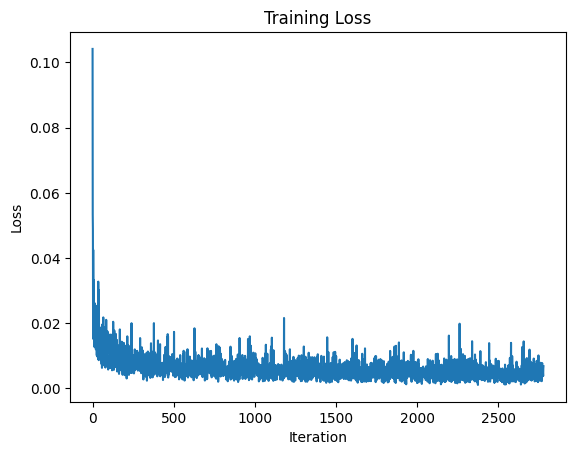

In [19]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

In [20]:
model.push_to_hub(model_repo_id)

model.safetensors:   0%|          | 0.00/57.5M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/iantc104/gaze_model_av_aloha_sim_slot_insertion/commit/773fe2c51ea37aadc77660283a2b9ee3ea4a997f', commit_message='Push model using huggingface_hub.', commit_description='', oid='773fe2c51ea37aadc77660283a2b9ee3ea4a997f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/iantc104/gaze_model_av_aloha_sim_slot_insertion', endpoint='https://huggingface.co', repo_type='model', repo_id='iantc104/gaze_model_av_aloha_sim_slot_insertion'), pr_revision=None, pr_num=None)

In [21]:
model = model.from_pretrained(model_repo_id).to(device)

config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/57.5M [00:00<?, ?B/s]

In [22]:
ranges = [
    [0, 500]
]
eval_dataset = Subset(dataset, sum([list(range(start, end)) for start, end in ranges], []))
eval_dataloader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

model.eval()
video = []
with torch.no_grad():
    for batch in tqdm(eval_dataloader, desc="Evaluation"):
        images = batch[image_keys[0]].to(device).squeeze(1)
        eye = batch[eye_keys[0]].to(device).squeeze(1)
        images = resize(images)
        pred, heatmaps = model(normalize(images))

        # Visualize a few examples
        for i in range(images.size(0)):
            img = images[i].cpu()
            img = (img * 255).byte().permute(1, 2, 0).numpy()
            heatmap = heatmaps[i].cpu()
            px = ((eye[i][0] + 1) / 2) * img.shape[1]
            py = ((eye[i][1] + 1) / 2) * img.shape[0]
            predx = ((pred[i][0] + 1) / 2) * img.shape[1]
            predy = ((pred[i][1] + 1) / 2) * img.shape[0]

            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
            heatmap = plt.cm.viridis(heatmap.numpy())  # Apply colormap
            heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
            overlay = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
            overlay = cv2.circle(overlay, (int(px), int(py)), 3, (0, 255, 0), -1)
            overlay = cv2.circle(overlay, (int(predx), int(predy)), 3, (255, 0, 0), -1)

            video.append(overlay)

# Save video
video_path = "mdn_saliency_video.mp4"
imageio.mimwrite(video_path, video, fps=25)

# Display video in Jupyter
display(Video(video_path, embed=True, width=512, height=384))


Evaluation: 100%|██████████| 8/8 [00:00<00:00, 11.10it/s]
